<a href="https://colab.research.google.com/github/amanzoni1/prove_varie/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

# Create 'modules' directory
os.makedirs("modules", exist_ok=True)

In [ ]:
%%writefile modules/data_setup.py
"""
Utility functions for creating PyTorch DataLoaders for various types of datasets
(e.g., image classification, generic datasets). This module provides flexibility to work
with multiple dataset formats.
"""

import os
from typing import Tuple, List, Optional, Union

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: Optional[str] = None,
    test_dir: Optional[str] = None,
    dataset: Optional[Dataset] = None,
    transform: Optional[transforms.Compose] = None,
    batch_size: int = 32,
    num_workers: int = NUM_WORKERS,
    shuffle_train: bool = True,
    pin_memory: bool = True
) -> Tuple[DataLoader, DataLoader, Optional[List[str]]]:
    """
    Creates PyTorch DataLoaders for training and testing data.

    Args:
        train_dir (Optional[str]): Path to training directory (for folder-based datasets like images).
        test_dir (Optional[str]): Path to testing directory (for folder-based datasets like images).
        dataset (Optional[Dataset]): A custom PyTorch Dataset (if using non-folder based datasets).
        transform (Optional[transforms.Compose]): Transforms to be applied on the data.
        batch_size (int): Number of samples per batch.
        num_workers (int): Number of workers for DataLoader.
        shuffle_train (bool): Whether to shuffle the training data.
        pin_memory (bool): Whether to use pinned memory in DataLoader (recommended for CUDA).

    Returns:
        Tuple[DataLoader, DataLoader, Optional[List[str]]]: Train DataLoader, Test DataLoader, and list of class names (if applicable).
    """

    if dataset is not None:
        # Custom Dataset case
        train_data, test_data = dataset['train'], dataset['test']
        class_names = dataset.get('classes', None)
    elif train_dir and test_dir:
        # Image folder case (directory based)
        train_data = datasets.ImageFolder(train_dir, transform=transform)
        test_data = datasets.ImageFolder(test_dir, transform=transform)
        class_names = train_data.classes
    else:
        raise ValueError("You must provide either `train_dir` and `test_dir` for folder-based datasets or a `dataset`.")

    # Create DataLoaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=shuffle_train,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,  # No need to shuffle test data
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    return train_dataloader, test_dataloader, class_names


def get_default_transforms(data_type: str = 'image') -> transforms.Compose:
    """
    Provides default transforms for datasets based on the type of data.

    Args:
        data_type (str): Type of the dataset (e.g., 'image', 'text', etc.)

    Returns:
        transforms.Compose: Default transformations applied to the data.
    """
    if data_type == 'image':
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        raise NotImplementedError(f"Transforms for {data_type} are not implemented yet.")

Writing modules/data_setup.py


In [ ]:
%%writefile modules/training_engine.py
"""
Generalized functions for training and evaluating a PyTorch model for classification and regression.
"""

from typing import Dict, List, Tuple, Optional
import torch
from tqdm.auto import tqdm

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               criterion: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               task_type: str = "classification") -> Tuple[float, Optional[float]]:
    """Performs one training step, updating model weights and returning loss and accuracy (if classification)."""
    model.train()
    train_loss, correct, total = 0, 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        if task_type == "classification":
            y_pred_class = torch.argmax(y_pred, dim=1)
            correct += (y_pred_class == y).sum().item()
        total += y.size(0)

    train_loss /= len(dataloader)
    train_acc = correct / total if task_type == "classification" else None

    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              criterion: torch.nn.Module,
              device: torch.device,
              task_type: str = "classification") -> Tuple[float, Optional[float]]:
    """Performs one evaluation step, returning loss and accuracy (if classification)."""
    model.eval()
    test_loss, correct, total = 0, 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            test_loss += criterion(y_pred, y).item()
            if task_type == "classification":
                y_pred_class = torch.argmax(y_pred, dim=1)
                correct += (y_pred_class == y).sum().item()
            total += y.size(0)

    test_loss /= len(dataloader)
    test_acc = correct / total if task_type == "classification" else None

    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          criterion: torch.nn.Module,
          epochs: int,
          device: torch.device,
          task_type: str = "classification") -> Dict[str, List[Optional[float]]]:
    """Runs full training and evaluation loop, returning metrics for each epoch."""
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, criterion, optimizer, device, task_type)
        test_loss, test_acc = test_step(model, test_dataloader, criterion, device, task_type)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_acc if train_acc is not None else 'N/A'}, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc if test_acc is not None else 'N/A'}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

Writing modules/training_engine.py


In [ ]:
%%writefile modules/utils.py
"""
Utility functions for PyTorch model training, saving, and additional tasks.
"""

from pathlib import Path
import torch

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model's state_dict to the specified directory.

    Args:
    model: A PyTorch model to save.
    target_dir: Directory to save the model.
    model_name: Name of the saved model file, should end with '.pth' or '.pt'.
    """
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)

    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model's state_dict
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(), f=model_save_path)


def load_model(model: torch.nn.Module,
               model_path: str,
               device: torch.device = torch.device("cpu")) -> torch.nn.Module:
    """Loads a PyTorch model's state_dict from a file.

    Args:
    model: The PyTorch model instance where the state_dict will be loaded.
    model_path: Path to the model state_dict file.
    device: The device to load the model on.

    Returns:
    The model with loaded parameters.
    """
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"[INFO] Loaded model from: {model_path}")
    return model


def save_training_results(results: dict,
                          target_dir: str,
                          filename: str = "training_results.json"):
    """Saves the training metrics (loss/accuracy) into a JSON file.

    Args:
    results: A dictionary containing training/test loss and accuracy.
    target_dir: Directory to save the results file.
    filename: Name of the JSON file to save results in.
    """
    import json
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)

    save_path = target_dir_path / filename
    with open(save_path, "w") as f:
        json.dump(results, f)

    print(f"[INFO] Saved training results to: {save_path}")

Writing modules/utils.py


In [ ]:
%%writefile modules/predictions.py
"""
Utility functions to make predictions and plot results for PyTorch models.

Reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
"""
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
from PIL import Image

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

def predict_and_plot(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: Optional[torchvision.transforms.Compose] = None,
    device: torch.device = device,
):
    """Makes a prediction on an image and plots the result.

    Args:
        model (torch.nn.Module): Pre-trained PyTorch model.
        class_names (List[str]): List of class names for the classification task.
        image_path (str): Path to the image file to predict on.
        image_size (Tuple[int, int], optional): Resize dimensions for the image. Defaults to (224, 224).
        transform (Optional[torchvision.transforms.Compose], optional): Optional transform to apply to the image. Defaults to None.
        device (torch.device, optional): Device to run predictions on. Defaults to detected device (CUDA if available, else CPU).

    Returns:
        None. Displays the image with predicted class and probability.
    """

    # Open and display the image
    img = Image.open(image_path)

    # Use provided transform or create a default one (ImageNet normalization)
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    # Transform the image and add batch dimension
    transformed_img = transform(img).unsqueeze(dim=0).to(device)

    # Set model to evaluation mode and make a prediction
    model = model.to(device)
    model.eval()
    with torch.inference_mode():
        pred_logits = model(transformed_img)

    # Convert logits to probabilities using softmax
    pred_probs = torch.softmax(pred_logits, dim=1)

    # Get the predicted class index
    pred_label_idx = torch.argmax(pred_probs, dim=1).item()

    # Plot the image and prediction result
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[pred_label_idx]} | Prob: {pred_probs[0][pred_label_idx]:.3f}")
    plt.axis("off")
    plt.show()

Writing modules/predictions.py


In [ ]:
# Imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torchvision import models
from torch.utils.data import DataLoader

# Importing utility functions
from modules.training_engine import train
from modules.predictions import predict_and_plot
from modules.utils import save_model

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Prepare Dataset and Dataloaders
# Apply basic transformations for training and testing sets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create DataLoader for training and test datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Get class names for CIFAR-10
class_names = train_dataset.classes

# 2. Initialize Model
# We'll use a pre-trained ResNet18 model and adjust it for CIFAR-10 (10 output classes)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=10)  # CIFAR-10 has 10 classes
model = model.to(device)


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]


<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer3): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), strid

In [ ]:
# 3. Set Up Loss Function (Criterion) and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 4. Train the Model
# Number of epochs to train the model for
epochs = 5

# Training loop
results = train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    criterion=criterion,  # Loss function
    epochs=epochs,
    device=device,
    task_type="classification"  # We're doing classification here
)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5: Train Loss: 1.1110, Train Acc: 0.62126, Test Loss: 0.8130, Test Acc: 0.7205
Epoch 2/5: Train Loss: 0.8157, Train Acc: 0.7245, Test Loss: 0.7408, Test Acc: 0.7546
Epoch 3/5: Train Loss: 0.7205, Train Acc: 0.7538, Test Loss: 0.6305, Test Acc: 0.7844
Epoch 4/5: Train Loss: 0.6635, Train Acc: 0.77772, Test Loss: 0.6417, Test Acc: 0.7828
Epoch 5/5: Train Loss: 0.6122, Train Acc: 0.79136, Test Loss: 0.6864, Test Acc: 0.7697


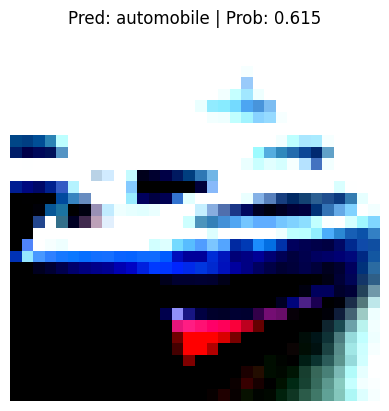

In [ ]:
# 6. Make Predictions on a Sample Image from the Dataset
# Get a sample image from the test dataset
def get_sample_image(dataloader: DataLoader, index: int = 0):
    """Fetch a sample image from the dataloader."""
    for images, labels in dataloader:
        return images[index], labels[index]

sample_image, _ = get_sample_image(test_loader, 1)

# Save the sample image to a file
from torchvision.utils import save_image
save_image(sample_image, 'sample_image.png')

# Run prediction and plot
predict_and_plot(
    model=model,
    class_names=class_names,
    image_path='sample_image.png',  # Path where we saved the sample image
    image_size=(32, 32),
    transform=transform_test,
    device=device
)

In [ ]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [1]:
import torch

In [2]:
torch.cuda.is_available()

True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

In [4]:
torch.__version__

'2.4.0+cu121'

In [5]:
torch.set_default_device(device)

In [6]:
x = torch.randn(12,2)
x

tensor([[ 0.3597, -0.2273],
        [ 1.0316, -2.1490],
        [-0.6349, -0.3419],
        [-0.4308, -0.4048],
        [-0.6609, -1.0943],
        [ 0.1506, -0.9823],
        [ 0.7264, -0.0828],
        [-0.2561, -1.7247],
        [ 1.8136, -0.0360],
        [ 1.0885,  1.3191],
        [ 1.7058, -0.8692],
        [ 0.5095,  1.5327]], device='cuda:0')

In [7]:
!nvidia-smi

Sat Sep 14 10:04:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0              26W /  70W |    121MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
torch.cuda.get_device_capability()

(7, 5)

In [11]:
free_gpu, total_gpu = torch.cuda.mem_get_info()

print(f'total free GPU memory: {round(free_gpu * 1e-9, 2)} GB')
print(f'total GPU memory: {round(total_gpu * 1e-9, 2)} GB')

total free GPU memory: 15.71 GB
total GPU memory: 15.84 GB


con free GPU sopra i 16GB circa e' ok alzare il batch size, anche a 128, e tenere size delle immagini piu grandi

In [4]:
pip install pycocotools

this is the original part but it takes too long so for now just try below.

In [2]:
# Create a directory to store the COCO dataset
!mkdir -p /content/coco_data

# Download COCO 2017 Train Images (~19GB)
!wget http://images.cocodataset.org/zips/train2017.zip -P /content/coco_data

# Download COCO 2017 Val Images (~1GB)
!wget http://images.cocodataset.org/zips/val2017.zip -P /content/coco_data

# Download COCO 2017 Annotations (~241MB)
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P /content/coco_data

--2024-09-16 12:14:37--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.226.81, 52.217.173.209, 3.5.25.239, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.226.81|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘/content/coco_data/train2017.zip’

train2017.zip         0%[                    ] 158.68M  1.07MB/s    eta 3h 2m  ^C
--2024-09-16 12:16:13--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.29.204, 16.182.40.121, 16.182.104.33, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.29.204|:80... connected.
HTTP request sent, awaiting response... ^C
--2024-09-16 12:16:14--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.29.204, 16.182.40.121, 16.182.

In [5]:
# Create a directory to store the COCO dataset
!mkdir -p /content/coco_data

# Download COCO 2017 Val Images (~1GB)
!wget http://images.cocodataset.org/zips/val2017.zip -P /content/coco_data

# Download COCO 2017 Annotations (~241MB)
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P /content/coco_data

# Extract the validation images and annotations
!unzip /content/coco_data/val2017.zip -d /content/coco_data/
!unzip /content/coco_data/annotations_trainval2017.zip -d /content/coco_data/

--2024-09-16 13:31:01--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.11.15, 3.5.27.45, 52.217.121.233, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.11.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘/content/coco_data/val2017.zip.1’

val2017.zip.1       100%[===================>] 777.80M  14.2MB/s    in 55s     

2024-09-16 13:31:56 (14.2 MB/s) - ‘/content/coco_data/val2017.zip.1’ saved [815585330/815585330]

--2024-09-16 13:31:56--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.112.41, 54.231.137.153, 52.217.104.124, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.112.41|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘/content/coco_d

In [6]:
from pycocotools.coco import COCO

# Load the COCO annotations file for training data
coco = COCO('/content/coco_data/annotations/instances_val2017.json')

# Specify the class for "person"
person_category_id = coco.getCatIds(catNms=['person'])[0]

# Get all image IDs that contain the "person" category
image_ids = coco.getImgIds(catIds=[person_category_id])

# Load image information for the first image in the dataset
image_info = coco.loadImgs(image_ids[0])[0]
print(image_info)

loading annotations into memory...
Done (t=0.77s)
creating index...
index created!
{'license': 3, 'file_name': '000000532481.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000532481.jpg', 'height': 426, 'width': 640, 'date_captured': '2013-11-20 16:28:24', 'flickr_url': 'http://farm7.staticflickr.com/6048/5915494136_da3cfa7c5a_z.jpg', 'id': 532481}


In [7]:
# Re-extract annotations
!unzip /content/coco_data/annotations_trainval2017.zip -d /content/coco_data/

Archive:  /content/coco_data/annotations_trainval2017.zip
replace /content/coco_data/annotations/instances_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
# Remove the corrupted file
!rm /content/coco_data/annotations_trainval2017.zip

In [9]:
# Redownload the COCO 2017 Annotations (~241MB)
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P /content/coco_data

--2024-09-16 13:38:48--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.0.27, 3.5.25.34, 3.5.27.133, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.0.27|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘/content/coco_data/annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  10.0MB/s    in 41s     

2024-09-16 13:39:29 (5.94 MB/s) - ‘/content/coco_data/annotations_trainval2017.zip’ saved [252907541/252907541]



In [10]:
# Extract annotations
!unzip /content/coco_data/annotations_trainval2017.zip -d /content/coco_data/

Archive:  /content/coco_data/annotations_trainval2017.zip
replace /content/coco_data/annotations/instances_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [11]:
# List files in the annotations folder
!ls /content/coco_data/annotations/

captions_train2017.json  instances_train2017.json  person_keypoints_train2017.json
captions_val2017.json	 instances_val2017.json    person_keypoints_val2017.json


In [12]:
from pycocotools.coco import COCO

# Load the COCO annotations file for training data
coco = COCO('/content/coco_data/annotations/instances_val2017.json')

# Specify the class for "person"
person_category_id = coco.getCatIds(catNms=['person'])[0]

# Get all image IDs that contain the "person" category
image_ids = coco.getImgIds(catIds=[person_category_id])

# Load image information for the first image in the dataset
image_info = coco.loadImgs(image_ids[123])[0]
print(image_info)

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!
{'license': 3, 'file_name': '000000442746.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000442746.jpg', 'height': 375, 'width': 500, 'date_captured': '2013-11-18 13:16:19', 'flickr_url': 'http://farm1.staticflickr.com/51/184784092_1f82c8701f_z.jpg', 'id': 442746}


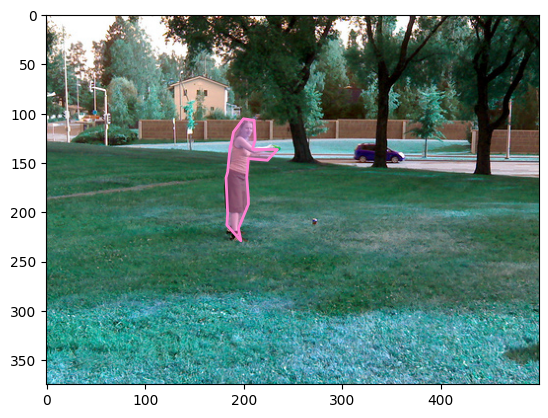

In [13]:
import matplotlib.pyplot as plt
import cv2
from pycocotools import mask

# Load the image file
img = cv2.imread(f'/content/coco_data/val2017/{image_info["file_name"]}')

# Get all annotation IDs for the image (person category)
ann_ids = coco.getAnnIds(imgIds=image_info['id'], catIds=[person_category_id], iscrowd=None)
annotations = coco.loadAnns(ann_ids)

# Draw the image and overlay the segmentation masks
plt.imshow(img)
coco.showAnns(annotations)
plt.show()

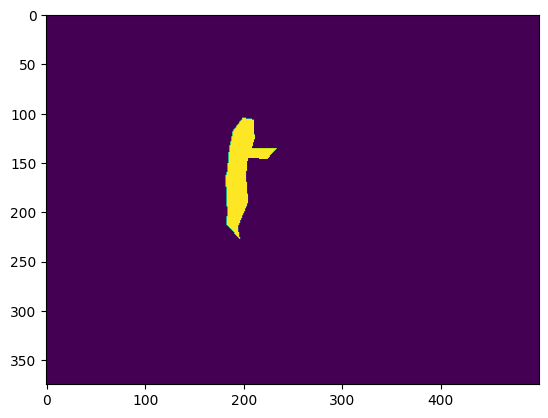

In [14]:
import numpy as np

# Initialize a blank mask (same dimensions as the image)
binary_mask = np.zeros((image_info['height'], image_info['width']))

# For each annotation, generate a binary mask
for ann in annotations:
    rle = coco.annToRLE(ann)
    m = coco.annToMask(ann)
    binary_mask = np.maximum(binary_mask, m)  # Combine all masks

# Show the binary mask
plt.imshow(binary_mask)
plt.show()

In [15]:
# Save binary mask as an image (for training)
cv2.imwrite(f'/content/coco_data/masks/mask_{image_info["file_name"]}', binary_mask * 255)  # Save as binary image (0 and 255)

False

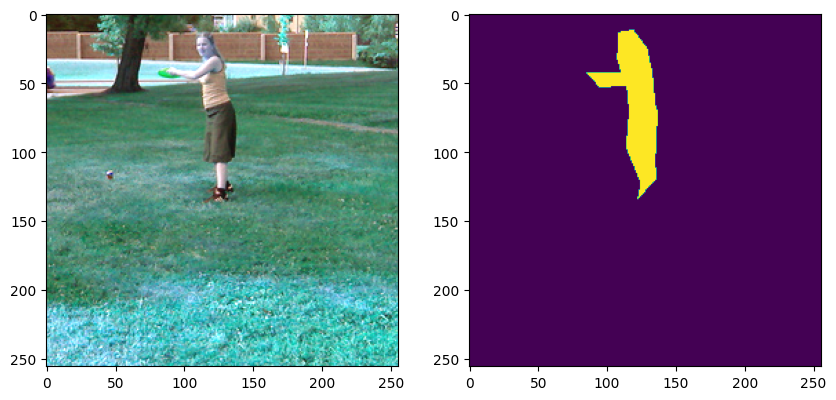

In [17]:
import albumentations as A

# Define augmentation pipeline
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomCrop(width=256, height=256),
    A.RandomBrightnessContrast(p=0.2),
])

# Apply augmentation on image and mask
augmented = augment(image=img, mask=binary_mask)
aug_img = augmented['image']
aug_mask = augmented['mask']

# Show augmented image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(aug_img)
plt.subplot(1, 2, 2)
plt.imshow(aug_mask)
plt.show();

In [69]:
torch.set_default_device('cpu')

In [18]:
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

# Load a pre-trained Mask R-CNN model
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = maskrcnn_resnet50_fpn(weights=weights)

# Put the model in evaluation mode (since we're not training yet)
model.eval()

# Move the model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [72]:
device = 'cpu'
device

'cpu'

In [19]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from torchvision.transforms import functional as F

class COCODataset(Dataset):
    def __init__(self, coco, image_ids, transforms=None):
        self.coco = coco
        self.image_ids = image_ids
        self.transforms = transforms

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]

        # Load image
        img_path = f"/content/coco_data/val2017/{image_info['file_name']}"
        img = Image.open(img_path).convert("RGB")

        # Load annotations
        ann_ids = self.coco.getAnnIds(imgIds=image_id, catIds=[person_category_id], iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)

        # Create empty mask
        masks = []
        for ann in anns:
            mask = self.coco.annToMask(ann)
            masks.append(mask)

        if len(masks) == 0:
            masks = [np.zeros(img.size[::-1], dtype=np.uint8)]

        # Convert masks to tensor
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)

        # Convert image to tensor
        img = F.to_tensor(img)

        # Prepare target
        target = {
            "masks": masks,
            "boxes": torch.tensor([ann['bbox'] for ann in anns], dtype=torch.float32),
            "labels": torch.tensor([ann['category_id'] for ann in anns], dtype=torch.int64)
        }

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

In [30]:
from torch.utils.data import DataLoader

# Example of loading a subset of image_ids for quick testing
image_ids = coco.getImgIds()[2:10]  # Load only first 10 images for testing

dataset = COCODataset(coco, image_ids)

# DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=lambda x: x)

In [31]:
def collate_fn(batch):
    images, targets = zip(*batch)
    return images, targets

dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)

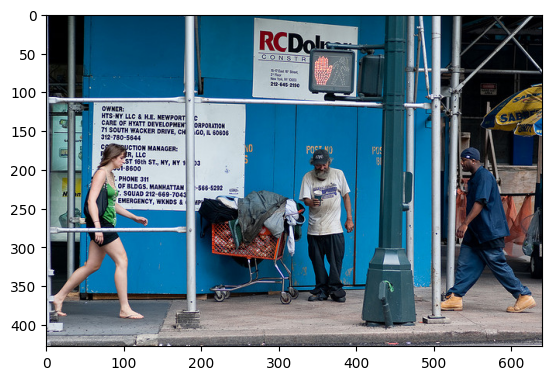

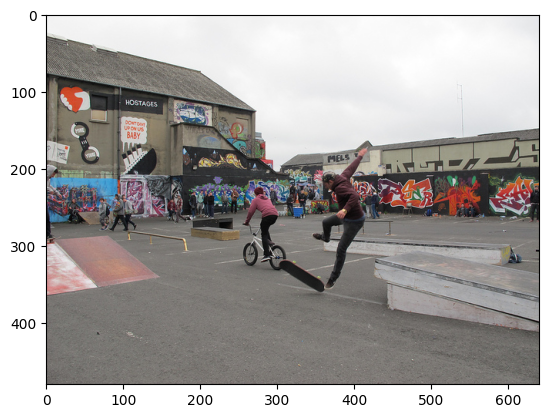

In [32]:
def visualize_batch(dataloader):
    imgs, targets = next(iter(dataloader))
    for img in imgs:
        img = img.cpu()  # Ensure image tensor is on CPU for visualization
        plt.imshow(F.to_pil_image(img))
        plt.show()

visualize_batch(dataloader)

In [23]:
device

device(type='cuda')

In [38]:
imgs, targets = next(iter(dataloader))
imgs[0].shape


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([3, 388, 640])

In [24]:
import torch.optim as optim

# Set up the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Set up the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [44]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for imgs, targets in dataloader:
        imgs = [img.to(device) for img in imgs]

        # Prepare targets and handle empty cases
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Ensure that targets list has the same length as imgs
        if len(imgs) != len(targets):
            print(f"Mismatch in number of images and targets: {len(imgs)} images, {len(targets)} targets")
            continue  # Skip this batch if there's a mismatch

        # Filter out empty targets
        targets = [t for t in targets if t["boxes"].numel() > 0]

        # Skip batch if no valid targets
        if len(targets) == 0:
            print("Skipping batch with no valid targets")
            continue

        # Forward pass
        loss_dict = model(imgs, targets)

        # Total loss
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    # Print epoch loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader)}")

    # Update the learning rate scheduler
    lr_scheduler.step()

IndexError: list index out of range

In [40]:
for imgs, targets in dataloader:
    print(f"Number of images in batch: {len(imgs)}")
    print(f"Number of targets in batch: {len(targets)}")

    # Additional debugging: check sizes of first image and target
    if len(imgs) > 0:
        print("First image size:", imgs[0].shape)
    if len(targets) > 0:
        print("First target boxes shape:", targets[0]["boxes"].shape)

    # Break after the first batch for debugging
    break

Number of images in batch: 2
Number of targets in batch: 2
First image size: torch.Size([3, 426, 640])
First target boxes shape: torch.Size([0])


In [42]:
for imgs, targets in dataloader:
    for i, target in enumerate(targets):
        print(f"Target {i}:")
        print("Boxes shape:", target["boxes"].shape)
        print("Labels shape:", target["labels"].shape)
    break  # Only check one batch

Target 0:
Boxes shape: torch.Size([0])
Labels shape: torch.Size([0])
Target 1:
Boxes shape: torch.Size([0])
Labels shape: torch.Size([0])


In [43]:
dataset = CustomDataset(...)  # Initialize your dataset here
img, target = dataset[0]  # Load the first sample

print("Image size:", img.size)
print("Target boxes:", target["boxes"])
print("Target labels:", target["labels"])

NameError: name 'CustomDataset' is not defined